# Identifying Entities in Healthcare Data

<hr style="border:1px solid blue">

An assignment to build a custom CRF Model to predict the treatment for a disease.

### Project Description
A health tech company called `BeHealthy` aims to connect the medical communities with millions of patients across the country.<br>
`BeHealthy` has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.<br>
So, companies like `BeHealthy` are providing medical services, prescriptions and online consultations and generating huge data day by day.<br>
With this huge amount of data, build a CRF Model to predict the treatment for a disease.

#### Data Set Brief Information
The data set contains snippet of medical data that may be generated when a doctor is writing notes to his/her patient or as a review of a therapy that he or she has done.
* train_sent - medical data of a patient with particular disease and treatments given. Train the CRF model using this data.
* test_sent - medical data of a patient with particular disease and treatments given. Test the CRF model using this data and predict treatments.
* train_label - label tags given for each token in training dataset
* test_label - label tags given for each token in test dataset

#### Business Objective
Perform the below mentioned tasks:
* Data preprocessing
* Concept identification
* Defining the features for CRF
* Getting the features words and sentences
* Defining input and target variables
* Building the model
* Evaluating the model
* Identifying the diseases and predicted treatment using a custom NER

#### Business Solution
Build a CRF Model to predict the treatment for a disease.

### Data Understanding
#### Import and Install useful packages.

In [1]:
# Install CRF python libraries
!pip install pycrf
!pip install sklearn-crfsuite

In [2]:
# Import all required libraries
# Import pandas
import pandas as pd
# Import spacy toolkit
import spacy
# Import Tokenizer to built custom tokenizer
from spacy.tokenizer import Tokenizer
# Import spacy util functions
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
# Import CRF library and its corresponding metrics
import sklearn_crfsuite
from sklearn_crfsuite import metrics
# Import Frequency Distribution from NLTK library
from nltk import FreqDist
# Import seaborn and matplotlib for visualizing
import seaborn as sns
import matplotlib.pyplot as plt
# To enable the inline plotting
%matplotlib inline

In [3]:
# Load the spacy model
model = spacy.load("en_core_web_sm")

### Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

#### Construct the proper sentences from individual words and print the 5 sentences.

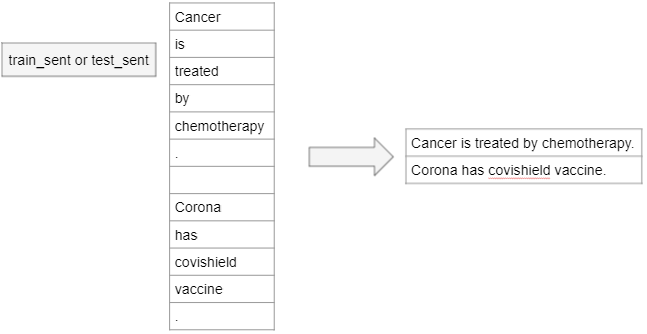

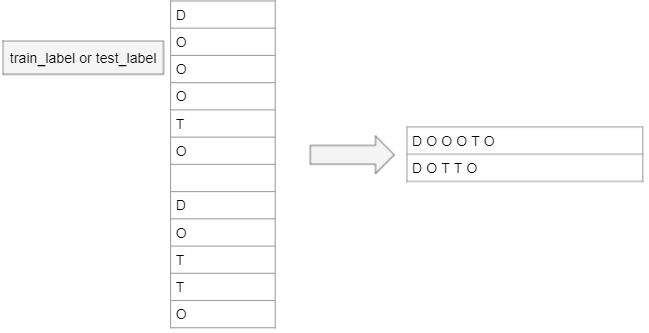

In [4]:
# Open all dataset files and read all lines
# Open train_sent file
with open('train_sent', 'r') as train_sent_file:
  train_sentences_list = train_sent_file.readlines()

# Open train_label file
with open('train_label', 'r') as train_labels_file:
  train_labels_list = train_labels_file.readlines()

# Open test_sent file
with open('test_sent', 'r') as test_sent_file:
  test_sentences_list = test_sent_file.readlines()

# Open test_label file
with open('test_label', 'r') as test_labels_file:
  test_labels_list = test_labels_file.readlines()

In [5]:
# Function to generate sentances from given list of words
def generate_sentences(list_of_sentences):
    temp_list = [] # Empty temporary list to append words
    sentences = [] # Empty list to store all sentances
    for item in list_of_sentences: # Loop through words
        if item != '\n': # Empty line not found
            temp_list.append(item[:-1]) # Remove '\n' at the end of each word and append in temporary list
        else: # Empty line found
            sentences.append(" ".join(temp_list)) # Join the list of words to form a sentance and append in main list
            temp_list.clear() # Clear temporary list for next iteration
    # Return list of sentances
    return sentences

In [6]:
# Merge words/tags to form complete sentance/tag
# Create sentance list for training dataset
train_sentences = generate_sentences(train_sentences_list)

# Create label list for training dataset
train_labels = generate_sentences(train_labels_list)

# Create sentance list for test dataset
test_sentences = generate_sentences(test_sentences_list)

# Create label list for test dataset
test_labels = generate_sentences(test_labels_list)

#### Print five sentences along with their labels

In [7]:
# Print first five sentances and their corresponding labels
for i in range(5):
    print("Sentance {}".format(i + 1))
    print("-"*10)
    print(" Sentance: {0}\n Label: {1}\n".format(train_sentences[i], train_labels[i]))

Sentance 1
----------
 Sentance: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
 Label: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Sentance 2
----------
 Sentance: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
 Label: O O O O O O O O O O O O O O O O O O O O O O O O O

Sentance 3
----------
 Sentance: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
 Label: O O O O O O O O O O O O O O O

Sentance 4
----------
 Sentance: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
 Label: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

#### Custom tokenization for medical data PoS tagging

The given **medical dataset is complex**. If we generally use spacy model to create PoS tags, it will break-up meaningful medical word and create separate tags!

Example:
* ``maternal-fetal`` is split in to 3 PoS Tags, but in genenral it is a combined word
* ``+\-3.0`` is a measure, but PoS tag will split it to '+', '\', '-', '3.0'

Like these examples, there are vast amount of cases to be considered before tokenizing the sentance using general method.

We will create a function to generate custom tokens from given medical data and PoS tag on such tokens.

In [8]:
# Function to create custom tokens for generating PoS tags
def custom_tokenizer(model):
    # Special case for tokens
    special_cases = {"``": [{"ORTH": "``"}], "''": [{"ORTH": "''"}], "+/-": [{"ORTH": "+/-"}]}
    infixes = list(model.Defaults.infixes) # Get list of current infix rules
    infixes = [x for x in infixes if '-|–|—|--|---|——|~' not in x] # Remove hyphens in infix rule
    infixes = [x for x in infixes if '<>=/' not in x] # Remove comparison symbols in infix rule
    infixes = [x for x in infixes if '+\-\*^' not in x] # Remove operator symbols in infix rule
    infix_re = compile_infix_regex(infixes) # Compile new infix rule
    prefixes = list(model.Defaults.prefixes) # Get list of current prefix rules
    prefixes = [x for x in prefixes if '=' not in x] # Remove equalto symbol in prefix rule
    prefixes = [x for x in prefixes if '\'' not in x] # Remove quote symbol in prefix rule
    prefixes = [x for x in prefixes if '+' not in x] # Remove plus symbol in prefix rule
    prefix_re = compile_prefix_regex(prefixes) # Compile new prefix rule

    # Return new tokenizer with custom rules, infix and prefix expressions
    return Tokenizer(model.vocab, rules=special_cases, prefix_search=prefix_re.search,
                                infix_finditer=infix_re.finditer)

In [9]:
# Update the model to use custom tokenizer
model.tokenizer = custom_tokenizer(model)

#### Count the number of sentences in the processed train and test dataset 

In [10]:
# Print the number of sentences in processed train and test dataset
print("Number of sentences in the processed train dataset = {}".format(len(train_sentences)))
print("Number of sentences in the processed test dataset = {}".format(len(test_sentences)))

Number of sentences in the processed train dataset = 2599
Number of sentences in the processed test dataset = 1056


#### Count the number of lines of labels in the processed train and test dataset.

In [11]:
# Print the number of labels in processed train and test dataset
print("Number of lines of labels in the processed train dataset = {}".format(len(train_labels)))
print("Number of lines of labels in the processed test dataset = {}".format(len(test_labels)))

Number of lines of labels in the processed train dataset = 2599
Number of lines of labels in the processed test dataset = 1056


### Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [12]:
# Combine train and test sentance sequences
combined_sentences = train_sentences + test_sentences
print("Number of sentences in combined dataset = {}".format(len(combined_sentences)))

Number of sentences in combined dataset = 3655


In [13]:
# Code to identify the NOUN and PROPN in combined sentance sequence
tokens = [] # List to append token
pos_tag = [] # List to append PoS tags
for sentence in combined_sentences: # Loop through all combined sequence list
    for token in model(sentence): # Get spacy processed sentance
        if token.pos_ in ['NOUN', 'PROPN']: # Check for NOUN or PROPN in PoS tag of current token
           tokens.append(token.text) # Append token if PoS tag is NOUN or PROPN
           pos_tag.append(token.pos_) # Append PoS tag of token

In [14]:
# Print PoS Tag list length
print("No. of tokens in combined dataset that have either 'NOUN' or 'PROPN' as their PoS tag = {}".format(len(tokens)))
print("Frequency of required PoS tags = {}".format(len(pos_tag)))

No. of tokens in combined dataset that have either 'NOUN' or 'PROPN' as their PoS tag = 23192
Frequency of required PoS tags = 23192


#### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [15]:
# Fuction to plot token frequency distribution
def plot_token_frequency(words, top_n=5):
    word_freq = FreqDist(words) # Get frequent of each tokens
    labels = [element[0] for element in word_freq.most_common(top_n)] # Generate list of top 'top_n' token names
    counts = [element[1] for element in word_freq.most_common(top_n)] # Generate list of top 'top_n' token count
    # Plot figure
    plt.figure(figsize = (10, 5))
    ax = sns.barplot(x = labels, y = counts)
    plt.xticks(rotation=90)
    plt.xlabel('Tokens', fontsize = 12)
    plt.ylabel('Frequency', fontsize = 12)
    plt.title('Token Frequency', fontsize = 15)
    ax.bar_label(ax.containers[0], fmt = '%d', padding = 3)
    plt.show()
    return labels, counts

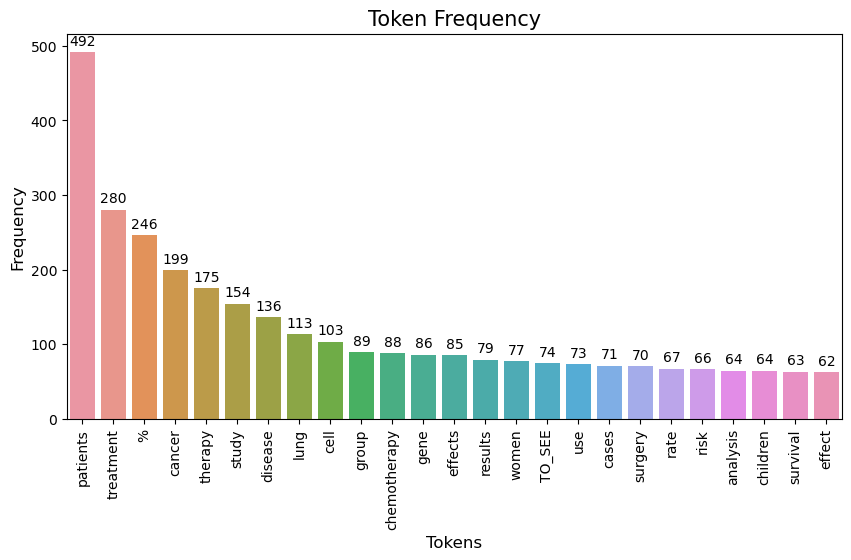

In [16]:
# Plot token frequency - top 25 most common tokens
labels, counts = plot_token_frequency(tokens, 25)

In [17]:
# Convert labels and counts to dataframe
df = pd.DataFrame({"Tokens" : labels, "Frequency" : counts})
print("Top 25 comon tokens with PoS tag of 'NOUN' or 'PROPN':\n")
df

Top 25 comon tokens with PoS tag of 'NOUN' or 'PROPN':



,Tokens,Frequency
0,patients,492
1,treatment,280
2,%,246
3,cancer,199
4,therapy,175
5,study,154
6,disease,136
7,lung,113
8,cell,103
9,group,89


### Defining features for CRF

In [18]:
# Function to define the features and get the feature value for one word.
def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos] # Get current word
    
    features = [
        'word.lower=' + word.lower(), # serves as word id
        'word[-3:]=' + word[-3:],     # last three characters
        'word[-2:]=' + word[-2:],     # last two characters
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
        'word.postag=' + pos_tags[pos] # get PoS tag of current word
    ]
    
    if(pos > 0):
        prev_word = sentence[pos-1] # Get previous word
        
        features.extend([
            'prev_word.lower=' + prev_word.lower(), # serves as previous word id
            'prev_word.isupper=%s' % prev_word.isupper(),  # is the previous word in all uppercase
            'prev_word.isdigit=%s' % prev_word.isdigit(),  # is the previous word a number
            'prev_words.startsWithCapital=%s' % prev_word[0].isupper(), # is the previous word starting with a capital letter
            'prev_words.postag=' + pos_tags[pos-1] # get PoS tag of previous word
        ])
    else:
        features.append('BEG') # feature to track begining of sentence 
    
    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence
    
    return features

### Getting the features
#### Write a code/function to get the features for a sentence

In [19]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    processed_sentance = model(sentence) # Get processed tokens from spacy model
    pos_tags = [] # List to store PoS tags
    
    for token in processed_sentance: # loop through processed tokens
        pos_tags.append(token.pos_) # Append PoS tags

    sentence_list = sentence.split() # Split the sentance
    # Loop through and get features of each tokens
    return [getFeaturesForOneWord(sentence_list, pos, pos_tags) for pos in range(len(sentence_list))]

In [20]:
# Get the features for a sentance to verify the functionality
example_sentence = train_sentences[5] # Get and print 5th sentance from train dataset
print(example_sentence)

# Get and print features of 5th sentance - 1st word from train dataset
features = getFeaturesForOneSentence(example_sentence)
features[1]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=rates',
 'word[-3:]=tes',
 'word[-2:]=es',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'word.postag=NOUN',
 'prev_word.lower=cesarean',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=True',
 'prev_words.postag=ADJ']

#### Write a code/function to get the labels of a sentence

In [21]:
# Function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [22]:
# Get the labels for a sentance to verify the functionality
example_labels = getLabelsInListForOneSentence(train_labels[5]) # Get and print 5th sentance labels from train dataset
print(example_labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Define input and target variables
Correctly computing X and Y sequence matrices for training and test data.<br>
Check that both sentences and labels are processed.

#### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [23]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

#### Define the labels as the target variable for test and the train dataset

In [24]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

### Build the CRF Model

In [25]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

# Mask Atrribute Error due to latest version of sklearn_crfsuite library
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

### Evaluation

#### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [26]:
# Predict the test dataset using CRF model
Y_pred = crf.predict(X_test)

#### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [27]:
# Print F1 score
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print("F1 score = {}".format(round(f1_score, 4)))

F1 score = 0.9045


In [28]:
# Print the orginal labels and predicted labels for the sentence in test data, which is at index value 10.
id = 10
print("Sentence:",test_sentences[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: The most common indication leading to diagnosis was abnormal ultrasound finding ( 48.2 % ) , followed by advanced maternal age ( 44.4 % )
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

#### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

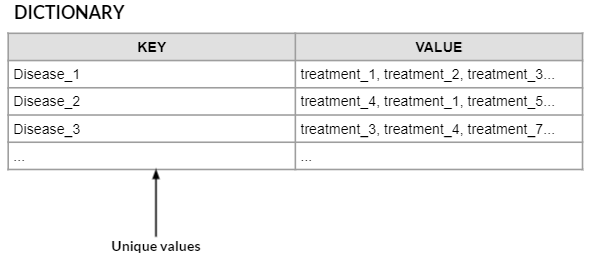

In [29]:
# Create a dictonary to hold disease as keys and treatments as values from test dataset
# Create empty dictionary
treatment_dict = dict()

# Loop through predicted test dataset labels
for i in range(len(Y_pred)):
    labels = Y_pred[i] # Get labels
    Diseases = "" # String to store disease
    Treatments = "" # String to store treatments of particular disease
    
    # loop through all labels
    for j in range(len(labels)):
        if labels[j] == 'D': # If label is D, it indicates a Disease
            # Append the disease
            Diseases += test_sentences[i].split()[j] + " "
        elif labels[j] == 'T': # If label is T, it indicates a Treatment
            # Append the treatment
            Treatments += test_sentences[i].split()[j] + " "
    
    # Strip any whitespaces present in Diseases and Treatments
    Diseases = Diseases.lstrip().rstrip()
    Treatments = Treatments.lstrip().rstrip()
    
    # Verify we don't have empty strings
    if Diseases != "" and Treatments != "":
        if Diseases in treatment_dict.keys(): # If disease is already in key, then append treatments
            treat_out = list(treatment_dict[Diseases])
            treat_out.append(Treatments)
            treatment_dict[Diseases] = treat_out
        elif Diseases not in treatment_dict.keys(): # Add new disease as key and its treatment
            treatment_dict[Diseases] = Treatments

#### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [30]:
# Predict the treatement for disease 'hereditary retinoblastoma'
print('Treatment for \'hereditary retinoblastoma\' is ', '\033[1m' + treatment_dict['hereditary retinoblastoma'] + '\033[0m')

Treatment for 'hereditary retinoblastoma' is  radiotherapy


<hr style="border:1px solid red">